In [5]:
from preamble import *

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv('./data/j_weather_data_v4.csv')
df.head()

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,inflow,outflow,is_weekend,dayofmonth,dayofweek,quarter,month,year,dayofyear,week,hour,minute,second
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,77.88,101.05,True,1,6,1,1,2023,1,52,0,0,0
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,107.09,119.92,True,1,6,1,1,2023,1,52,1,0,0
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,143.67,124.54,True,1,6,1,1,2023,1,52,2,0,0
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,144.95,80.16,True,1,6,1,1,2023,1,52,3,0,0
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,159.06,104.88,True,1,6,1,1,2023,1,52,4,0,0


In [7]:
df.shape

(15527, 20)

In [8]:
feature = df.drop('datetime', axis=1)
target = df['outflow'].values.reshape(-1, 1)

train_size = int(feature.shape[0] * 0.7)

trainset_feature = feature[:train_size]
trainset_target = target[:train_size]
testset_feature = feature[train_size:]
testset_target = target[train_size:]

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler_feature = MinMaxScaler()
train_feature_scaled = scaler_feature.fit_transform(trainset_feature)
test_feature_scaled = scaler_feature.transform(testset_feature)

scaler_target = MinMaxScaler()
train_target_scaled = scaler_target.fit_transform(trainset_target)
test_target_scaled = scaler_target.transform(testset_target)

In [10]:
import pickle

with open('./model/scaler_feature_lstm_250211.pkl', 'wb') as f:
  pickle.dump(scaler_feature, f)
with open('./model/scaler_target_lstm_250211.pkl', 'wb') as f:
  pickle.dump(scaler_target, f)

In [11]:
valid_size = int(train_feature_scaled.shape[0] * 0.9)

train_feature_scale = train_feature_scaled[:valid_size]
train_target_scale = train_target_scaled[:valid_size]
valid_feature_scaled = train_feature_scaled[valid_size:]
valid_target_scaled = train_target_scaled[valid_size:]

In [12]:
def split_dataset(data, target, seq_len, pred_len):
  X, y = [], []
  for i in range(data.shape[0] - (seq_len + pred_len) + 1):
    X.append(data[i:i + seq_len, :])
    y.append(target[i + seq_len:i + seq_len + pred_len])
  return np.array(X), np.array(y)

seq_len = 168
pred_len = 24

In [13]:
X_train, y_train = split_dataset(train_feature_scaled, train_target_scaled, seq_len, pred_len)
X_valid, y_valid = split_dataset(valid_feature_scaled, valid_target_scaled, seq_len, pred_len)
X_test, y_test = split_dataset(test_feature_scaled, test_target_scaled, seq_len, pred_len)

X_train_tensor, y_train_tensor = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_valid_tensor, y_valid_tensor = torch.tensor(X_valid).float(), torch.tensor(y_valid).float()
X_test_tensor, y_test_tensor = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [14]:
from torch.utils.data import DataLoader, TensorDataset

loader_train = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True,
                                           batch_size=128)
loader_valid = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), shuffle=True,
                                           batch_size=128)
loader_test = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), shuffle=False,
                                          batch_size=128)

In [15]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    last_out = lstm_out[:, -1, :]
    out = self.fc(last_out)
    return out

input_size = 19
hidden_size = 50
output_size = 24
model = LSTMModel(input_size, hidden_size, output_size)


In [16]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
def evaluate(model, valid_dataset, criterion, device):
  val_loss = 0
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in valid_dataset:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)
      logits =model(batch_X)
      batch_y = batch_y.view(batch_y.size(0), -1)
      loss = criterion(logits, batch_y)
      val_loss += loss.item()
  return val_loss

In [18]:
best_valid_loss = float('inf')
num_epochs = 300
loss_history = []
model.to(device)
for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  for X_batch, y_batch in loader_train:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    out = model(X_batch)
    y_batch = y_batch.view(y_batch.size(0), -1)
    loss = loss_fn(out, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  loss_history.append(train_loss / len(loader_train.dataset))
  valid_loss = evaluate(model, loader_valid, loss_fn, device)
  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss}')
  print(f'Valid Loss : {valid_loss}')
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), './model/best_lstm_checkpoint_250211.pt')

Epoch : 1 / 300
Train Loss : 5.070968568325043
Valid Loss : 0.26861273869872093
Epoch : 2 / 300
Train Loss : 3.0179508812725544
Valid Loss : 0.22649608552455902
Epoch : 3 / 300
Train Loss : 2.294873457401991
Valid Loss : 0.16294914484024048
Epoch : 4 / 300
Train Loss : 1.733365811407566
Valid Loss : 0.11805684491991997
Epoch : 5 / 300
Train Loss : 1.53515237942338
Valid Loss : 0.11733208037912846
Epoch : 6 / 300
Train Loss : 1.517517225816846
Valid Loss : 0.1139256153255701
Epoch : 7 / 300
Train Loss : 1.5051472820341587
Valid Loss : 0.11165807023644447
Epoch : 8 / 300
Train Loss : 1.4916694983839989
Valid Loss : 0.109766885638237
Epoch : 9 / 300
Train Loss : 1.4815110675990582
Valid Loss : 0.10928979888558388
Epoch : 10 / 300
Train Loss : 1.4749419540166855
Valid Loss : 0.11020735837519169
Epoch : 11 / 300
Train Loss : 1.4657530393451452
Valid Loss : 0.10893364995718002
Epoch : 12 / 300
Train Loss : 1.458420118317008
Valid Loss : 0.1093911798670888
Epoch : 13 / 300
Train Loss : 1.4467

In [19]:
model.load_state_dict(torch.load('./model/best_lstm_checkpoint_250211.pt'))
model.to(device)

C:\Users\user\AppData\Local\Temp\ipykernel_18836\3533519276.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/best_lstm_checkpoin

LSTMModel(
  (lstm): LSTM(19, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=24, bias=True)
)

In [20]:
model.eval()

y_pred_list = []
with torch.no_grad():
  for X_batch, _ in loader_test:
    X_batch = X_batch.to(device)
    y_pred = model(X_batch).cpu().numpy()
    y_pred_list.append(y_pred)

y_pred = np.concatenate(y_pred_list, axis=0)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

y_test_ori = scaler_target.inverse_transform(y_test.reshape(-1, pred_len))
y_pred_ori = scaler_target.inverse_transform(y_pred)

mse = mean_squared_error(y_test.reshape(-1, pred_len), y_pred)
mse_ori = mean_squared_error(y_test_ori, y_pred_ori)
rmse = np.sqrt(mse)
rmse_ori = np.sqrt(mse_ori)
r2 = r2_score(y_test.reshape(-1, pred_len), y_pred)
print(f'RMSE : {rmse}, RMSE_ORI : {rmse_ori} R-value : {r2}')

RMSE : 0.17728594093958394, RMSE_ORI : 47.77723272362398 R-value : 0.25529334559745126


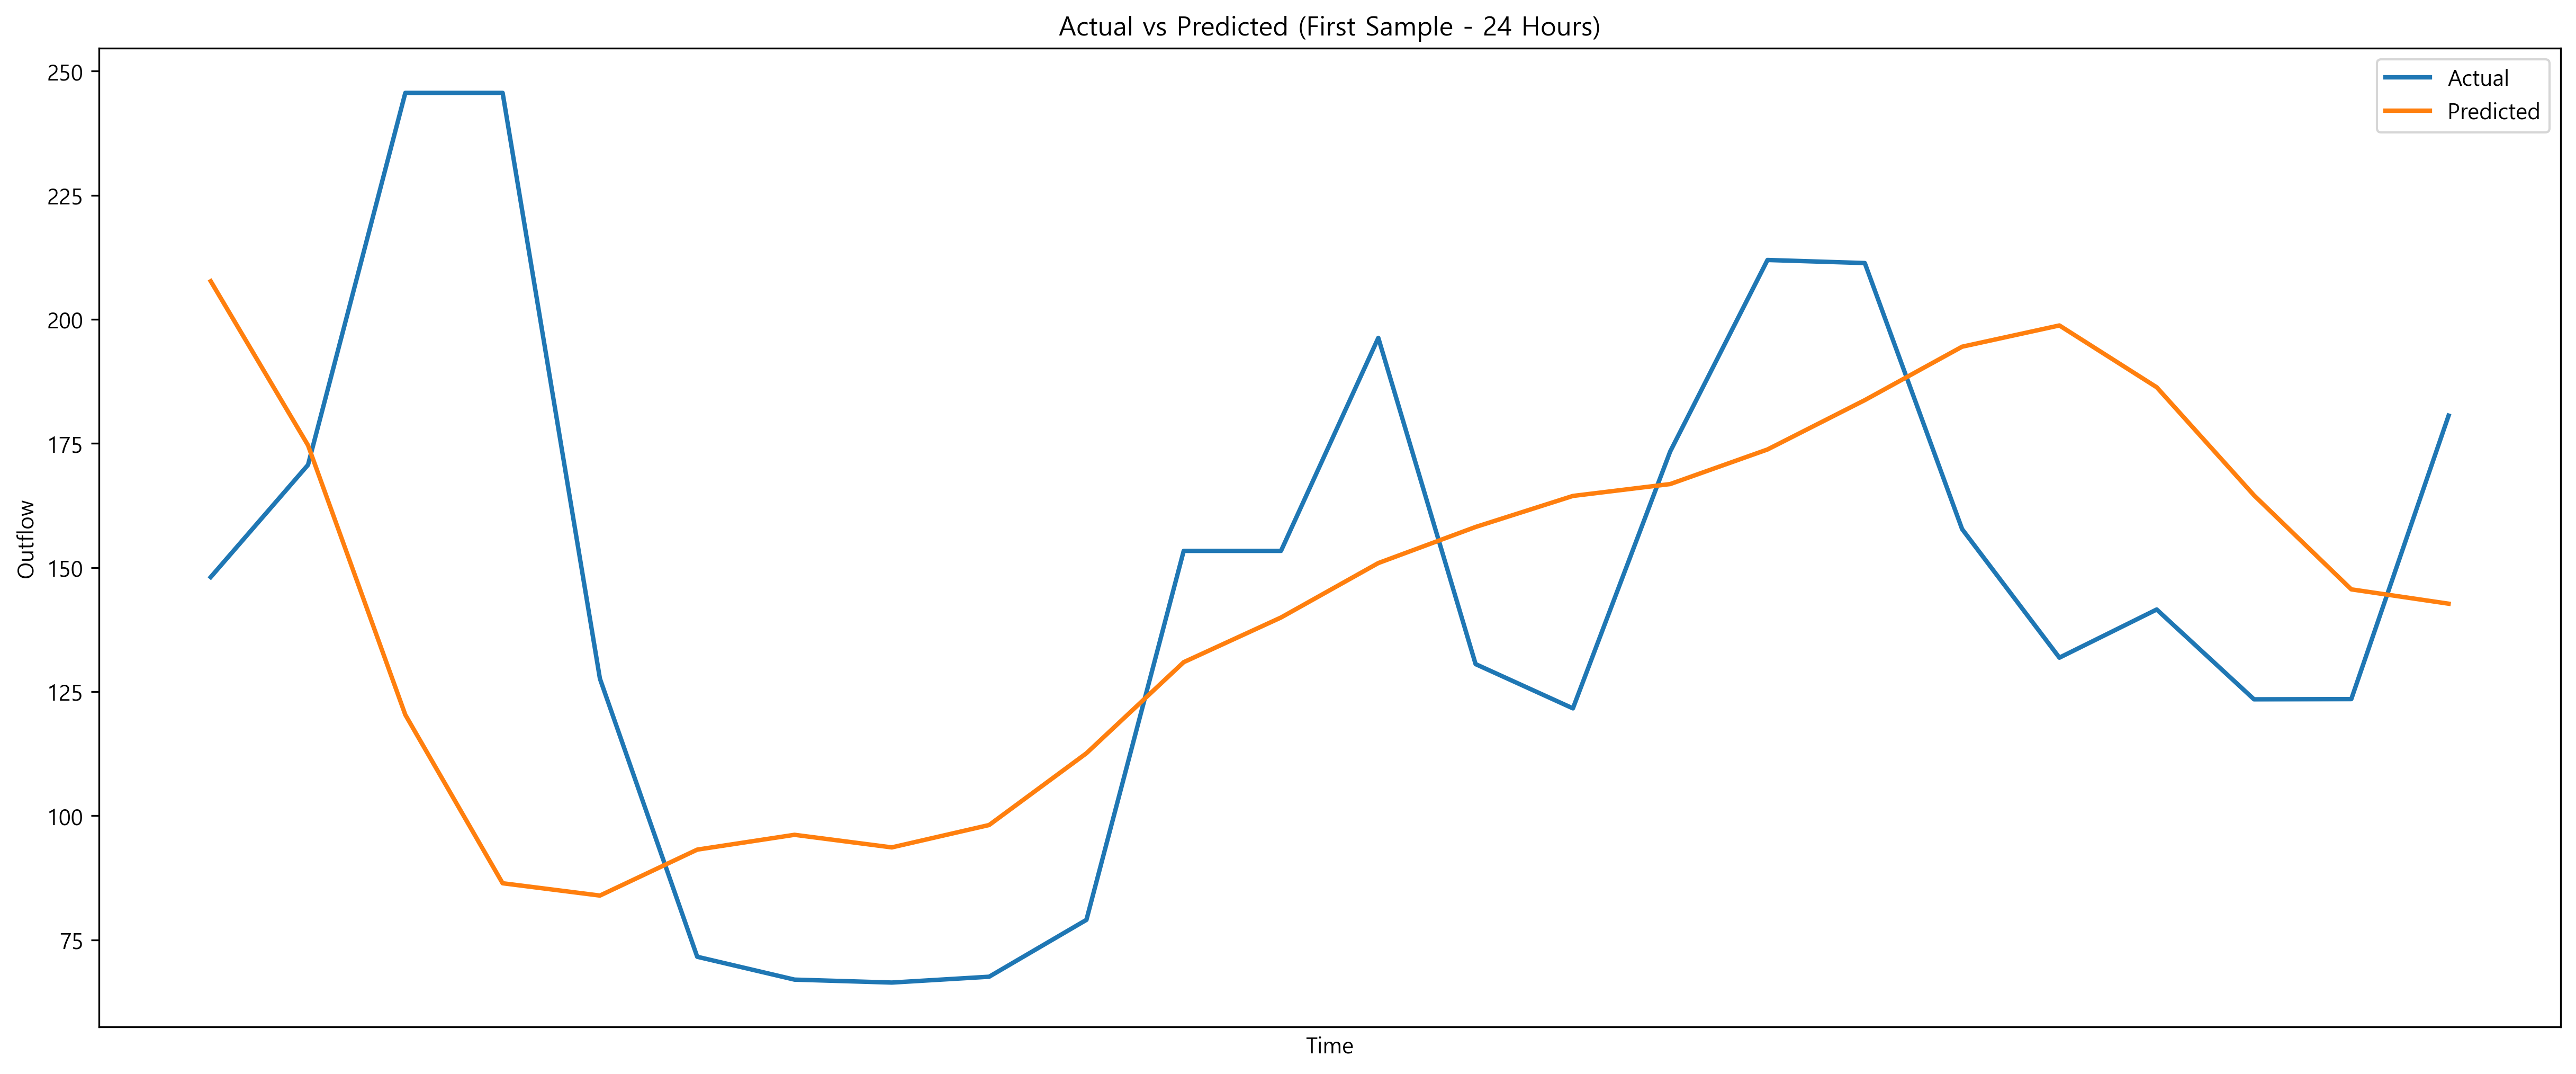

In [22]:
# 예측 결과 시각화 (첫 번째 샘플의 24시간 예측)
plt.figure(figsize=(20, 8))
plt.xticks([])

actual_data = y_test_ori[0]
predicted_data = y_pred_ori[0]

time_index = df.index[train_size + seq_len:train_size + seq_len + pred_len]

plt.plot(time_index, actual_data, label='Actual')
plt.plot(time_index, predicted_data, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted (First Sample - 24 Hours)')
plt.xlabel('Time')
plt.ylabel('Outflow')
plt.show()

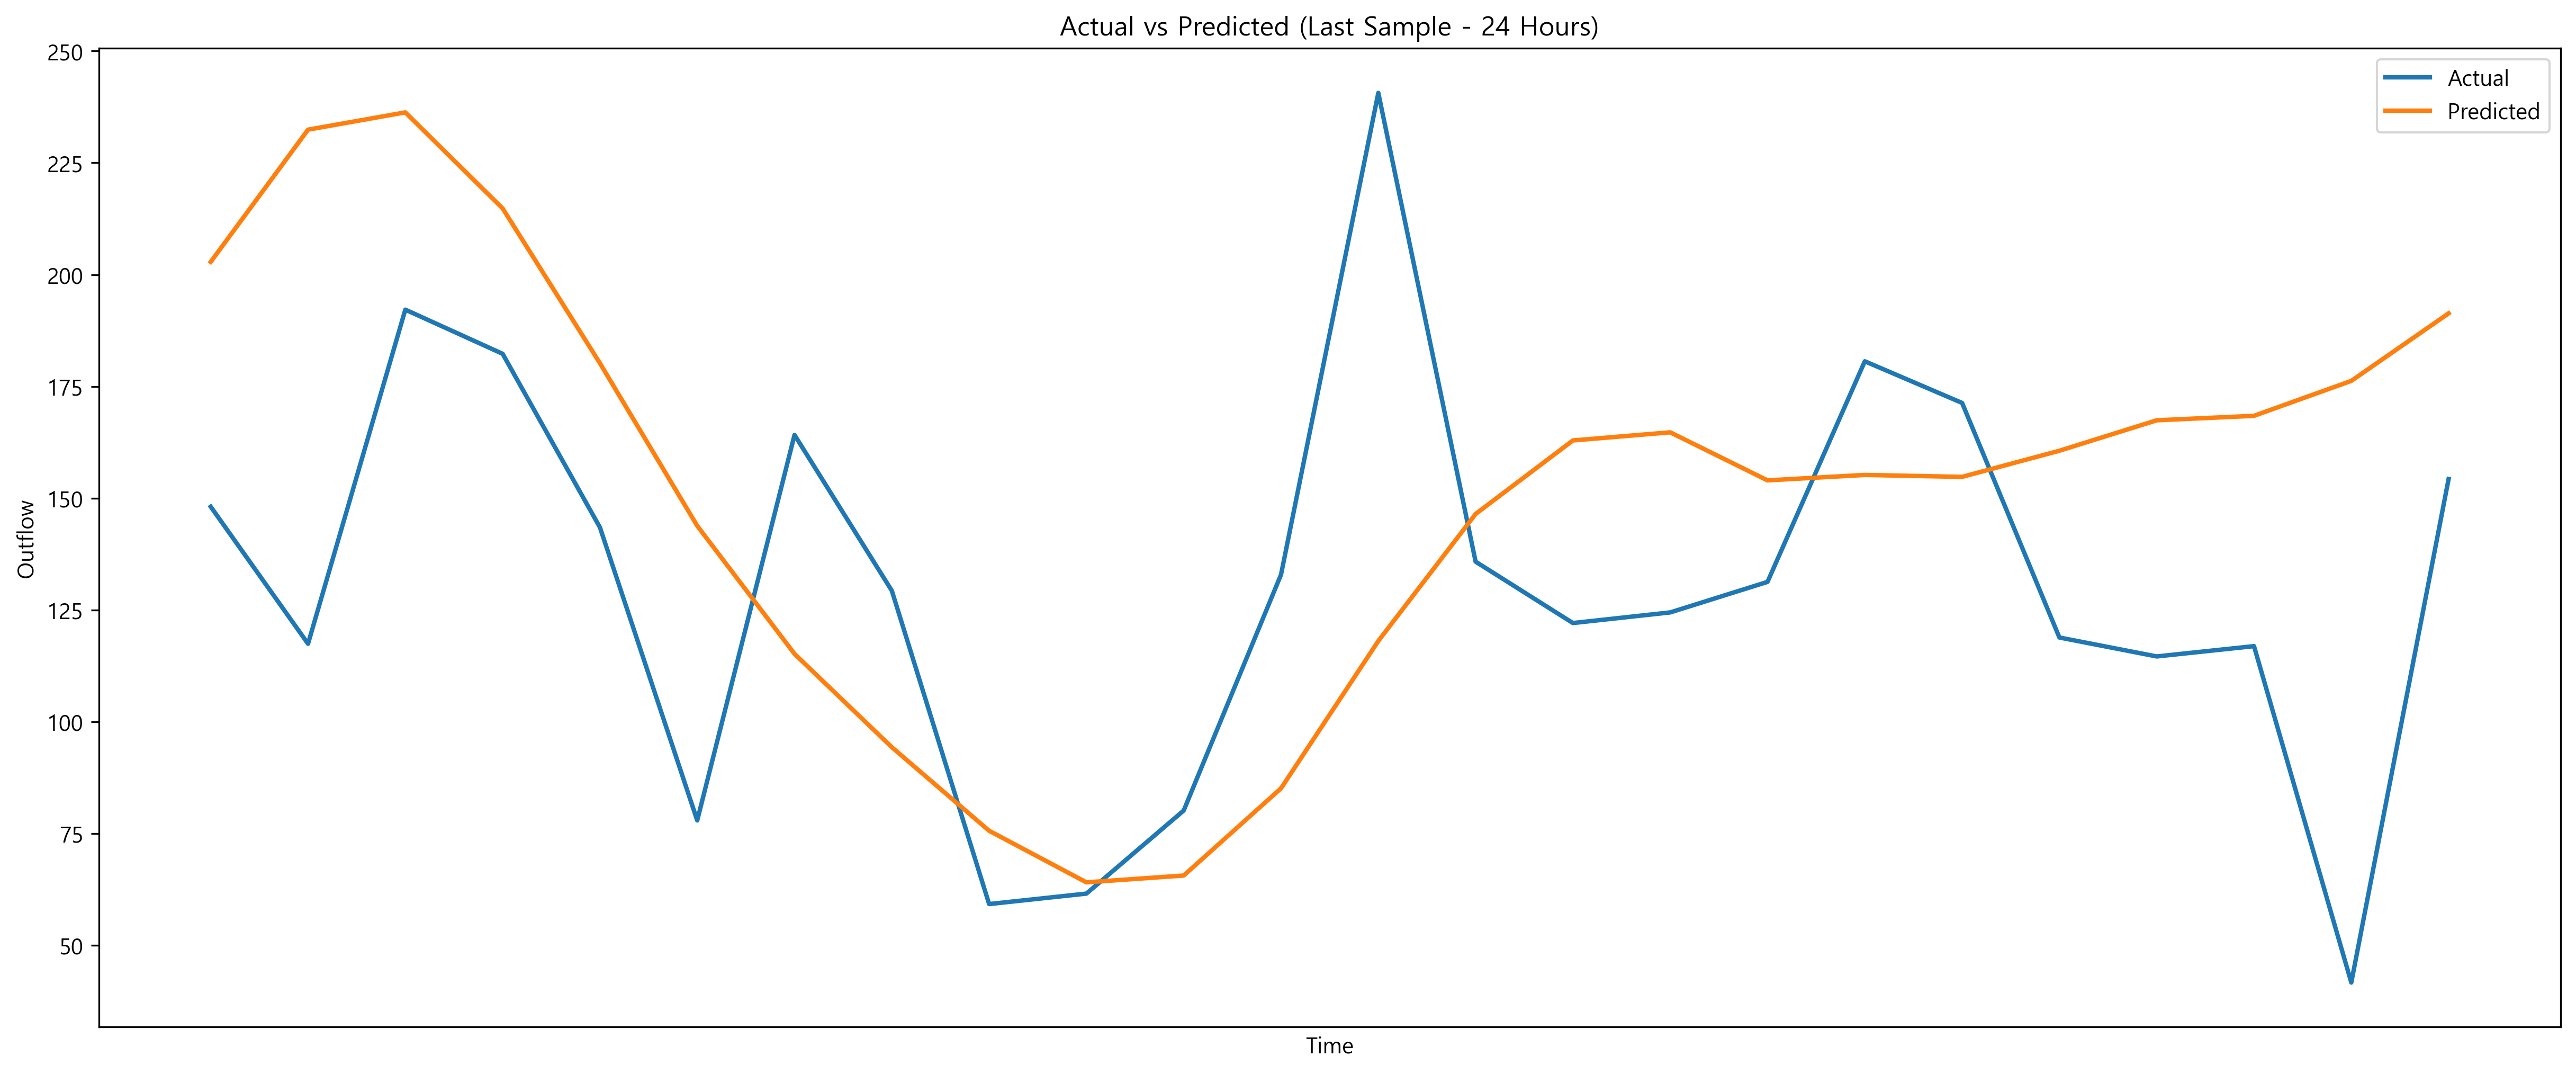

In [23]:
plt.figure(figsize=(20, 8))
plt.xticks([])

actual_data = y_test_ori[-1]
predicted_data = y_pred_ori[-1]

start_index = train_size + seq_len + (len(y_test)-1)
time_index = df.index[start_index:start_index + pred_len]


plt.plot(time_index, actual_data, label='Actual')
plt.plot(time_index, predicted_data, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted (Last Sample - 24 Hours)')
plt.xlabel('Time')
plt.ylabel('Outflow')
plt.show()